# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
import time
import pickle
import numpy as np
import tensorflow as tf
import csv
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.optimizers import Adam, SGD
from keras.layers import Input, Flatten, Dense, Conv2D, Add, Lambda, Cropping2D, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout, Concatenate
from keras.models import Model

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

ADAPT_LEARNING_RATE = False
DISABLE_PRINTS = False
EVALUATE_BATCH_TRAINING = False
AUGMENT_DATA = True
TRAIN_MODEL = True
GRAY_SCALE = True
LEARNING_CURVE = False # If False trains for all the training set

# Load pickled data
training_file = './traffic-signs-data/train.p'

validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

train_dict = pickle.load(open(training_file, mode='rb') )
valid_dict = pickle.load(open(validation_file, mode='rb'))
test_dict  = pickle.load(open(testing_file, mode='rb'))

coords_train, X_train, sizes_train, y_train = train_dict['coords'], train_dict['features'], train_dict['sizes'], train_dict['labels']

X_valid, y_valid = valid_dict['features'], valid_dict['labels']
X_test, y_test = test_dict['features'], test_dict['labels']

Using TensorFlow backend.


In [2]:
from cv2 import createCLAHE

def isGrayScale(image):
    if image.shape[-1] == 3 and len(image.shape) == 3:
        return False
    else:
        return True
    
def histogram_equalize_image(image, gridSize = (4, 4)):
    clahe = createCLAHE(tileGridSize=gridSize)
    if isGrayScale(image): 
        image = clahe.apply(image)            
        return image
    else:
        img_YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)            
        img_YCrCb[...,0] = clahe.apply(img_YCrCb[...,0])            
        image = cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2RGB)
        return image

def normalize_image(image):
    # pixels after normalization are in range [-0.5, +0.5]
    return (image - np.min(image))/(np.max(image)-np.min(image)) - 0.5

def preprocess_image(image, grayscale = GRAY_SCALE):  
    if grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)       
    return normalize_image(histogram_equalize_image(image))

def preprocess_data(X_data):
    return np.array([preprocess_image(image) for image in X_data]).reshape(X_data.shape[0], 32,32,-1)


def augment_data(X_data, enable = False):
    return np.array([random_transform_image(image, enable) for image in X_data]).reshape(X_data.shape[0], 32,32,-1)



In [3]:
def list_images(images, xaxis = "", yaxis ="", cmap=None, ncols = 10, title = ''):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            yaxis (Default = " "): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(10, 10))    
    n_images = len(images)
    nrows = np.ceil(n_images/ncols) 

    for i in range(n_images):
        plt.subplot(nrows, ncols, i+1)
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if images[i].shape[-1] != 3 else cmap
        plt.imshow(np.squeeze(images[i]), cmap = cmap)
        plt.xlabel(xaxis)
        plt.ylabel(yaxis)
        plt.xticks([])
        plt.yticks([])    
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)    
    plt.title(title, loc = 'center', fontsize=16)        
    plt.show()        

    
def rotate_image(image, angle_range = (5, 15)):
    random_angle = np.random.uniform(angle_range[0], angle_range[1], size = 1)*(np.random.randint(2, size=1)*2-1)
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, random_angle, scale = 1)
    return(cv2.warpAffine(image, rot_mat, image.shape[1::-1]))

def change_brightness_image(image):  
    random_bright = np.random.uniform(0.75, 1.25)
    if not isGrayScale(image):
        image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)        
        image[:,:,0] = image[:,:,0]*random_bright
        image = cv2.cvtColor(image,cv2.COLOR_YCrCb2RGB)    
        return image
    else:        
        image = image*random_bright       
        return image

def motion_blur_image(image):
    size = 3
    # generating the kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size
    return cv2.filter2D(image, -1, kernel_motion_blur)
    
def random_transform_image(img, enable = False):    
    id_transformation = np.random.randint(4)
    if not enable or id_transformation == 0:
        return img
    
    
    if np.random.uniform(0, 1, size = 1) > 0.8:
        return motion_blur_image(change_brightness_image(rotate_image(img)))
    else:
        return change_brightness_image(rotate_image(img))
    


In [4]:
def evaluate(X_data, y_data):
    # ********************** hyper-parameters ************************
    batch_size  = 1024 # non consequential parameter for eval
    # ********************** **********************************************
    
    num_examples    = X_data.shape[0]
    totalAccuracy   = 0
    totalLoss       = 0

    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        end = np.minimum(offset + batch_size, num_examples)
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        batch_accuracy, batch_loss = sess.run([accuracy_operation, loss_operation], 
                                              feed_dict={x: batch_x, 
                                                           y: batch_y, 
                                                           BN: False, 
                                                           keep_prob_fc: np.ones(2).reshape([2, 1]),
                                                           beta_regularization: np.zeros(2).reshape([2, 1])})
        totalAccuracy   += (batch_accuracy * batch_x.shape[0])
        totalLoss       += (batch_loss * batch_x.shape[0])

    return {"loss": totalLoss/num_examples, "accuracy": totalAccuracy/num_examples}



def train_model(X_train, y_train, X_valid, y_valid, hyperPar_dict):    
    # ********************** read hyper-parameters ************************
    epochs              = hyperPar_dict['epochs']
    batch_size          = hyperPar_dict['batch_size']
    learning_rate       = hyperPar_dict['learning_rate']
    batch_norm          = hyperPar_dict['batch_norm']
    keep_probability_fc = hyperPar_dict['keep_prob_fc']
    beta_regularization_parameters = hyperPar_dict['beta_regularization']
    # ********************** ********************* ************************
    
    training_loss       = np.zeros(epochs)
    training_accuracy   = np.zeros(epochs)
    validation_loss     = np.zeros(epochs)
    validation_accuracy = np.zeros(epochs)    
    
    
    with tf.Session() as sess:               
        sess.run(tf.global_variables_initializer())                
        for i in range(epochs): 
            t1 = time.time()
            if (i+1)%20 == 0 and ADAPT_LEARNING_RATE:
                learning_rate *= 0.3
            
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, X_train.shape[0], batch_size):
                end = np.minimum(offset + batch_size, X_train.shape[0])
                batch_x, batch_y = preprocess_data(augment_data(X_train[offset:end], enable = AUGMENT_DATA)), y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, 
                                                        y: batch_y, 
                                                        BN: batch_norm, 
                                                        learn_rate: learning_rate,
                                                        keep_prob_fc: keep_probability_fc,
                                                        beta_regularization: beta_regularization_parameters})

            t2 = time.time()            
            # **************** update results after an epoch ************************
            if EVALUATE_BATCH_TRAINING:
                training_results_dict   = evaluate(preprocess_data(X_train[offset:end]), y_train[offset:end])
            else:
                training_results_dict   = evaluate(preprocess_data(X_train), y_train)

            validation_results_dict = evaluate(X_valid, y_valid)
            t3 = time.time()

            training_accuracy[i]    = training_results_dict['accuracy']
            training_loss[i]        = training_results_dict['loss']        
            validation_accuracy[i]  = validation_results_dict['accuracy']
            validation_loss[i]      = validation_results_dict['loss']        
            # *********************************************************************** 
            if not DISABLE_PRINTS:            
                print("EPOCH {} ...".format(i+1))
                print("Time taken = {:.2f}, {:.2f} ".format((t2-t1), (t3-t2)))
                print("Learning rate = {:.3f}".format(learning_rate*1000))
                print("Training Accuracy = {:.3f}".format(training_accuracy[i]))
                print("Training Loss = {:.3f}".format(training_loss[i]))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy[i]))
                print("Validation Loss = {:.3f}".format(validation_loss[i]))
                print()
            
        saver.save(sess, './OptimizedModel')
            
    
    results_dict = {"training_accuracy": training_accuracy,
        "validation_accuracy": validation_accuracy,
        "training_loss": training_loss,
        "validation_loss": validation_loss}
    return results_dict


def learning_curve(X_train, y_train, X_valid, y_valid, hyperPar_dict, step_size = 2048):
    training_accuracy_list      = []
    training_loss_list          = []
    validation_accuracy_list    = []    
    validation_loss_list        = []
    
    step_size = np.minimum(step_size, X_train.shape[0])
    
    
    for m_train in range(step_size, X_train.shape[0]+1, step_size):            
        m_valid = int(np.minimum(np.round(m_train*.15), X_valid.shape[0]))
        print("Training using {training_samples} training samples and {valid_samples} validation samples"
              .format(training_samples = m_train, valid_samples = m_valid))
        print()

        X_train, y_train = shuffle(X_train, y_train)
        X_valid, y_valid = shuffle(X_valid, y_valid)        
        #*******************************************
        # Train the model for m samples
        # ******************************************
        results_dict_mSamples = train_model(X_train[0:m_train], y_train[0:m_train],
        X_valid[0:m_valid], y_valid[0:m_valid], 
        hyperPar_dict)            

        training_accuracy_list.append(results_dict_mSamples['training_accuracy'])
        training_loss_list.append(results_dict_mSamples['training_loss'])

        validation_accuracy_list.append(results_dict_mSamples['validation_accuracy'])
        validation_loss_list.append(results_dict_mSamples['validation_loss'])
        

    learning_curve_results = {
        "training_accuracy": np.array(training_accuracy_list),
        "training_loss": np.array(training_loss_list),
        "validation_accuracy": np.array(validation_accuracy_list),
        "validation_loss": np.array(validation_loss_list)
    }   
    

    return learning_curve_results


def display_stats(X_train, y_train, X_valid, y_valid):
    # Number of training examples
    n_train = X_train.shape[0]

    # Number of validation examples
    n_valid = X_valid.shape[0]

    # Number of testing examples.
    n_test = X_test.shape[0]

    # shape of an traffic sign image
    image_shape = np.array([X_train.shape[1], X_train.shape[2]])

    # How many unique classes/labels there are in the dataset.
    N_CLASSES = len(np.unique(y_train))

    # bin count of different classes
    n_train_images_in_a_Class = np.bincount(y_train)

    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_valid)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", N_CLASSES)

    # Mapping ClassID to traffic sign names
    signs = []
    signnames = csv.reader(open('signnames.csv', 'r'), delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    

def display_samples(X_data, coords = None, sizes = None):
    # Display sample images
    disp_sample_idx  = np.random.randint(0, X_data.shape[0], 10)

    # display original samples
    print('original images')
    list_images(X_data[disp_sample_idx])

    print('boxed original images')
    list_images(get_boxed_images(data_set   = X_data[disp_sample_idx], coords = coords[disp_sample_idx], sizes = sizes[disp_sample_idx]))
    print('Cropped images')
    list_images(get_cropped_images(data_set = X_data[disp_sample_idx], coords = coords[disp_sample_idx], sizes = sizes[disp_sample_idx]))

    # display normalized samples
    print('normalized images')
    list_images(normalize_dataset(X_data[disp_sample_idx]))

    print('histogram equalized gray scale images')
    list_images(histogram_equalization(X_data[disp_sample_idx]))



def explore_data(X_train, y_train, X_valid, y_valid):
    # explore data set for random 1000 images
    sample_id  = np.random.randint(0, X_train.shape[0], 1000)
    # Mean and variance image of a data set
    X_explore_data = X_train[sample_id]

    mean_img = np.mean(X_explore_data, axis = 0).astype('uint8')
    std_img = np.std(X_explore_data, axis = 0).astype('uint8')
    list_images([mean_img, std_img])
    # Compute histogram of entropy
    # pixel_variance(data_set, equalize = False)
    variance_data = histogram_equalization(X_explore_data, equalize = False)
    plt.hist(variance_data)
    plt.show()

    # Histogram of train
    hist_y_train = np.bincount(y_train)
    hist_y_valid = np.bincount(y_valid)

    nhist_y_train = hist_y_train
    nhist_y_valid = hist_y_valid

    y_pos = np.arange(len(np.unique(y_train)))
    fig, ax = plt.subplots()
    ax.bar(y_pos, nhist_y_train, 0.35, align='center', alpha=0.5, color = 'b', label = 'train')
    #ax.bar(y_pos, nhist_y_valid, 0.8, align='center', alpha=0.5, color = 'g', label = 'valid')
    ax.set_ylabel('count of images in a class')
    ax.set_xlabel('class ID')
    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
    plt.show() 

    fig, ax = plt.subplots()
    #ax.bar(y_pos, nhist_y_train, 0.35, align='center', alpha=0.5, color = 'b', label = 'train')
    ax.bar(y_pos, nhist_y_valid, 0.8, align='center', alpha=0.5, color = 'g', label = 'valid')
    ax.set_ylabel('count of images in a class')
    ax.set_xlabel('class ID')
    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
    plt.show() 

    print("Distribution of different classes in training is \n", (hist_y_train))     




---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

----

## Step 2: Design and Test a Model Architecture

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Model Architecture

In [5]:
### Define your architecture here.
import tensorflow as tf
from tensorflow.contrib.layers import flatten, batch_norm

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def activation(x, func = 'relu', BN = False):
    if BN == True:
        if func == 'relu':
            return batch_norm(tf.nn.relu(x)) 
        elif func == 'elu':
            return batch_norm(tf.nn.elu(x))
        elif func == 'lrelu':
            return batch_norm(tf.nn.leaky_relu(x, alpha = 0.1))
        else:
            assert False, " unsupported activation function used"
    else:
        if func == 'relu':
            return tf.nn.relu(x)
        elif func == 'elu':
            return tf.nn.elu(x)
        elif func == 'lrelu':
            return tf.nn.leaky_relu(x, alpha = 0.1)
        else:
            assert False, " unsupported activation function used"
    

def conv2d(x, W, b, strides=1):
    return tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID') + b
    

# tf.constant(value,dtype=None)    
def LeNet(x, batch_norm = False, keep_prob_fc = np.ones(2).reshape([2 , 1]),
         beta_regularization = np.zeros(2).reshape([2 , 1])):   

    if GRAY_SCALE:
        n_channels = 1
    else:
        n_channels = 3
        
    BN_flag = batch_norm
    activation_func = 'relu'
    
    # conv1: Input = 32x32X1. Output = 28x28x6.
    # Weights = 5X5X1X6 = 150
    wc1 = tf.get_variable("wc1", shape = [5, 5, n_channels, 6], initializer=tf.contrib.layers.xavier_initializer())
    bc1 = tf.Variable(tf.zeros(6))
    conv1 = conv2d(x, wc1, bc1)
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    maxp1 = maxpool2d(conv1, k=2)
    #Activation. Output = 14x14x6.
    layer1_out = activation(maxp1, func = activation_func, BN = BN_flag)

    
    # conv2: Input = 14x14X6. Output = 10x10x16.
    # Weights = 5X5X6X16 = 2.4k
    wc2 = tf.get_variable("wc2", shape = [5, 5, 6, 16], initializer=tf.contrib.layers.xavier_initializer())
    bc2 = tf.Variable(tf.zeros(16))
    conv2 = conv2d(layer1_out, wc2, bc2)
    #Pooling. Input = 10x10x16.. Output = 5x5x16..
    maxp2 = maxpool2d(conv2, k=2)
    #Activation. Output = 5x5x16.
    layer2_out = activation(maxp2, func = activation_func, BN = BN_flag)

    
    # Flatten. Input = 5x5x16. Output = 400
    fc3_inp = flatten(layer2_out)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    # Weights = 400*120 = 48k
    wfc3 = tf.get_variable("wfc3", shape = [400, 120], initializer=tf.contrib.layers.xavier_initializer())
    bfc3 = tf.Variable(tf.zeros(120))    
    # Sameer: change tf.add and tf.multiply
    fc3  = tf.add(tf.matmul(fc3_inp,wfc3),bfc3)
    # TODO: Activation.
    layer3_out = activation(fc3, func = activation_func, BN = BN_flag)
    layer3_out = tf.nn.dropout(layer3_out, keep_prob_fc[0,0])


    # Layer 4: Fully Connected. Input = 120. Output = 84.
    # Weights = 120*84 ~ 10k
    wfc4 = tf.get_variable("wfc4", shape = [120, 84], initializer=tf.contrib.layers.xavier_initializer())
    bfc4 = tf.Variable(tf.zeros(84))    
    fc4  = tf.add(tf.matmul(layer3_out, wfc4),bfc4)
    # TODO: Activation.
    layer4_out = activation(fc4, func = activation_func, BN = BN_flag)
    layer4_out = tf.nn.dropout(layer4_out, keep_prob_fc[1,0])
    

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    # Weights = 84*43 ~ 3.6k
    # Biases = 43
    wfc5 = tf.get_variable("wfc5", shape = [84, 43], initializer=tf.contrib.layers.xavier_initializer())
    bfc5 = tf.Variable(tf.zeros(43))    
    fc5  = tf.add(tf.matmul(layer4_out, wfc5),bfc5)
    logits = fc5
   

    regularizers = beta_regularization[0,0] * tf.nn.l2_loss(wfc3) + beta_regularization[1,0]*tf.nn.l2_loss(wfc4)
    return logits, regularizers



## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Training Pipeline


In [6]:
if GRAY_SCALE:
    n_channels = 1
else:
    n_channels = 3


#************************************************************************************
#                               INPUT-Variables
#************************************************************************************
x = tf.placeholder(tf.float32, (None, 32, 32, n_channels))
y = tf.placeholder(tf.int32, (None))
# Regularization
keep_prob_fc = tf.placeholder(tf.float32, shape = (2, 1))
beta_regularization = tf.placeholder(tf.float32, shape = (2, 1))
# Learning rate
learn_rate = tf.placeholder(tf.float32, (None))
# Batch norm
BN = tf.placeholder(tf.bool, (None))





N_CLASSES = 43
one_hot_y = tf.one_hot(y, N_CLASSES)


#************************************************************************************
#                               Choose the neural network model
#************************************************************************************
logits, regularizers = LeNet(x, batch_norm = BN, keep_prob_fc = keep_prob_fc, beta_regularization = beta_regularization)
saver = tf.train.Saver()
#************************************************************************************


#************************************************************************************
#               Define compute nodes of interest in a given graph
#************************************************************************************
cross_entropy  = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(tf.reduce_mean(cross_entropy) + regularizers)

optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate)
training_operation = optimizer.minimize(loss_operation)

prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# Train the Model


In [7]:
#X_train = preprocess_data(train_dict['features'])
X_valid = preprocess_data(valid_dict['features'])
X_test  = preprocess_data(test_dict['features'])

if not LEARNING_CURVE:
    step_size = X_train.shape[0]

# ********************** Set hyper-parameters ************************
hyperPar_dict = {"epochs": 100,
"batch_size": 64,
"learning_rate": 1e-3,
"batch_norm": True,
"keep_prob_fc": np.array([0.5, 0.5]).reshape([2, 1]),
"beta_regularization": np.array([0, 0]).reshape([2, 1])}
# ********************** ********************* ************************
    
learning_curve_results = learning_curve(X_train, y_train, X_valid, y_valid, hyperPar_dict, step_size)

training_accuracy_vs_m = learning_curve_results['training_accuracy'][:,-1]
training_loss_vs_m = learning_curve_results ['training_loss'][:,-1]
validation_accuracy_vs_m = learning_curve_results['validation_accuracy'][:,-1]
validation_loss_vs_m = learning_curve_results['validation_loss'][:,-1]


Training using 34799 training samples and 4410 validation samples

EPOCH 1 ...
Time taken = 21.65, 11.19 
Learning rate = 1.000
Training Accuracy = 0.774
Training Loss = 0.802
Validation Accuracy = 0.730
Validation Loss = 0.905

EPOCH 2 ...
Time taken = 23.30, 11.31 
Learning rate = 1.000
Training Accuracy = 0.884
Training Loss = 0.397
Validation Accuracy = 0.849
Validation Loss = 0.472

EPOCH 3 ...
Time taken = 23.82, 11.23 
Learning rate = 1.000
Training Accuracy = 0.922
Training Loss = 0.261
Validation Accuracy = 0.879
Validation Loss = 0.361

EPOCH 4 ...
Time taken = 23.32, 11.22 
Learning rate = 1.000
Training Accuracy = 0.941
Training Loss = 0.198
Validation Accuracy = 0.909
Validation Loss = 0.277

EPOCH 5 ...
Time taken = 23.64, 11.25 
Learning rate = 1.000
Training Accuracy = 0.952
Training Loss = 0.168
Validation Accuracy = 0.921
Validation Loss = 0.244

EPOCH 6 ...
Time taken = 23.42, 11.85 
Learning rate = 1.000
Training Accuracy = 0.963
Training Loss = 0.145
Validation Acc

EPOCH 51 ...
Time taken = 23.61, 11.33 
Learning rate = 1.000
Training Accuracy = 0.995
Training Loss = 0.017
Validation Accuracy = 0.968
Validation Loss = 0.125

EPOCH 52 ...
Time taken = 23.37, 11.35 
Learning rate = 1.000
Training Accuracy = 0.995
Training Loss = 0.017
Validation Accuracy = 0.972
Validation Loss = 0.122

EPOCH 53 ...
Time taken = 23.65, 11.24 
Learning rate = 1.000
Training Accuracy = 0.995
Training Loss = 0.019
Validation Accuracy = 0.975
Validation Loss = 0.108

EPOCH 54 ...
Time taken = 23.53, 11.54 
Learning rate = 1.000
Training Accuracy = 0.995
Training Loss = 0.021
Validation Accuracy = 0.968
Validation Loss = 0.142

EPOCH 55 ...
Time taken = 24.20, 11.26 
Learning rate = 1.000
Training Accuracy = 0.995
Training Loss = 0.019
Validation Accuracy = 0.968
Validation Loss = 0.119

EPOCH 56 ...
Time taken = 23.50, 11.74 
Learning rate = 1.000
Training Accuracy = 0.995
Training Loss = 0.019
Validation Accuracy = 0.972
Validation Loss = 0.125

EPOCH 57 ...
Time take

In [8]:
with tf.Session() as sess:
    saver.restore(sess,  './OptimizedModel')
    train_results_dict   = evaluate(preprocess_data(X_train), y_train)
    print("Train Accuracy = {:.3f}".format(train_results_dict['accuracy']))
    print("Train Loss = {:.3f}".format(train_results_dict['loss']))
    test_results_dict   = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_results_dict['accuracy']))
    print("Test Loss = {:.3f}".format(test_results_dict['loss']))

INFO:tensorflow:Restoring parameters from ./OptimizedModel
Train Accuracy = 0.997
Train Loss = 0.011
Test Accuracy = 0.955
Test Loss = 0.185


In [9]:
training_accuracy_vs_iter = learning_curve_results['training_accuracy'][0,:]
training_loss_vs_iter = learning_curve_results['training_loss'][0,:]
validation_accuracy_vs_iter = learning_curve_results['validation_accuracy'][0,:]
validation_loss_vs_iter = learning_curve_results['validation_loss'][0,:]

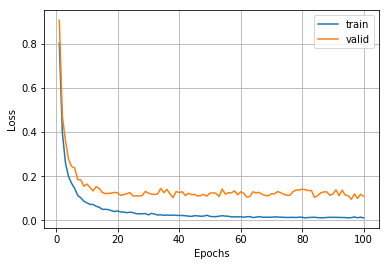

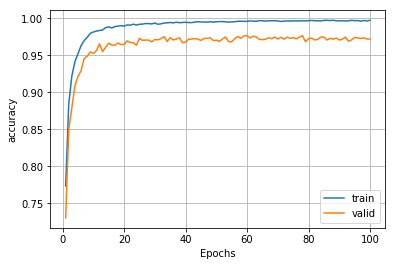

In [10]:
%matplotlib inline
num = 0
plt.figure()
for i in range(learning_curve_results['training_accuracy'].shape[0]):
    if i==num:
        training_loss_vs_iter = learning_curve_results['training_loss'][i,:]
        validation_loss_vs_iter = learning_curve_results['validation_loss'][i,:]    
        plt.plot(np.arange(1, len(training_loss_vs_iter)+1), training_loss_vs_iter, label = 'train')
        plt.plot(np.arange(1, len(validation_loss_vs_iter)+1), validation_loss_vs_iter, label = 'valid')

plt.xlabel('Epochs')
plt.ylabel('Loss')
legend = plt.legend(loc='best')
plt.grid(True)
plt.show()

%matplotlib inline
plt.figure()
for i in range(learning_curve_results['training_accuracy'].shape[0]):
    if i==num:
        training_accuracy_vs_iter = learning_curve_results['training_accuracy'][i,:]
        validation_accuracy_vs_iter = learning_curve_results['validation_accuracy'][i,:]    
        plt.plot(np.arange(1, len(training_accuracy_vs_iter)+1), training_accuracy_vs_iter, label = 'train')
        plt.plot(np.arange(1, len(validation_accuracy_vs_iter)+1), validation_accuracy_vs_iter, label = 'valid')

plt.xlabel('Epochs')
plt.ylabel('accuracy')
legend = plt.legend(loc='best')
plt.grid(True)
plt.show()

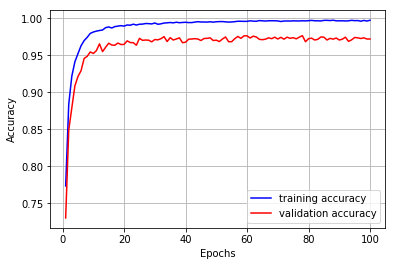

In [11]:
%matplotlib inline
plt.figure()
plt.plot(np.arange(1, len(training_accuracy_vs_iter)+1), training_accuracy_vs_iter, 'b', label = 'training accuracy')
plt.plot(np.arange(1, len(validation_accuracy_vs_iter)+1), validation_accuracy_vs_iter, 'r', label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
legend = plt.legend(loc='best')
plt.grid(True)
plt.show()

In [12]:
print(np.argmax(validation_accuracy_vs_iter))
print(np.max(validation_accuracy_vs_iter))
print(np.argmax(training_accuracy_vs_iter))
print(np.max(training_accuracy_vs_iter))

77
0.9764172351279227
87
0.9972125628052156
